In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

In [ ]:
df = pd.read_csv('fire_incident.csv')
df.columns = [c.strip() for c in df.columns]

In [ ]:
df.head()

,Date,Year,Time,Day_of_Week,Barangay,Latitude,Longitude,Weather,Property_Type,Fire_Cause,Fire_Type,Fire_Severity,Casualty_Count,Response_Time,Fire_Duration
0,18/11/2021,2021.0,18:10,Thursday,I-C (Bagong Bayan),14.076365,121.310982,Sunny,Residential,Natural,Grass Fire,Medium,7.0,6.0,55.0
1,23/02/2023,2023.0,19:54,Thursday,Santa Veronica (Bae),14.068024,121.320271,Rainy,Residential,Cooking,Residential Fire,High,7.0,12.0,15.0
2,01/09/2021,2021.0,1:12,Wednesday,I-A (Sambat),14.072499,121.316021,Sunny,Residential,Electrical,Electrical Fire,Medium,2.0,11.0,41.0
3,16/08/2022,2022.0,2:10,Tuesday,VI-A (Mavenida),14.072298,121.330864,Stormy,Residential,Other,Other Fire,Medium,1.0,14.0,170.0
4,10/12/2024,2024.0,15:42,Tuesday,San Lucas 2 (Malinaw),14.063669,121.320900,Cloudy,Residential,Cooking,Residential Fire,High,11.0,9.0,64.0


In [ ]:
df.columns

Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Property_Type', 'Fire_Cause', 'Fire_Type',
       'Fire_Severity', 'Casualty_Count', 'Response_Time', 'Fire_Duration'],
      dtype='object')

In [ ]:
df.shape

(1500, 15)

In [ ]:
required = ['Year', 'Barangay', 'Fire_Type', 'Fire_Cause', 'Casualty_Count']
missing = [col for col in required if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

In [ ]:
X = df[['Year', 'Barangay', 'Fire_Type', 'Fire_Cause']]
y = df['Casualty_Count'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Barangay', 'Fire_Type', 'Fire_Cause'])
    ],
    remainder='drop'
)

In [ ]:
# Random Forest pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
# Train model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay', 'Fire_Type',
                                                   'Fire_Cause'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# Make predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

In [ ]:
print("=== Random Forest - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== Random Forest - Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.6652    0.7990       230
           1     0.7407    1.0000    0.8511       220

    accuracy                         0.8289       450
   macro avg     0.8704    0.8326    0.8250       450
weighted avg     0.8733    0.8289    0.8244       450



=== Random Forest - Confusion Matrix ===
[[153  77]
 [  0 220]]


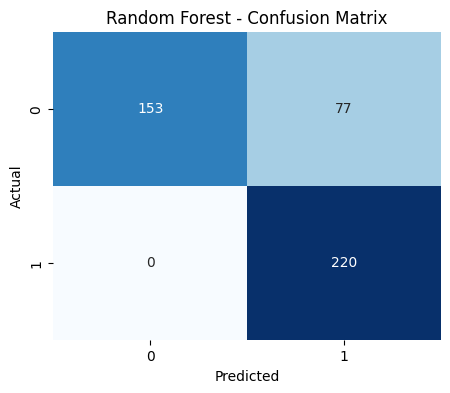

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== Random Forest - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Random Forest - ROC AUC: 0.8192 ===


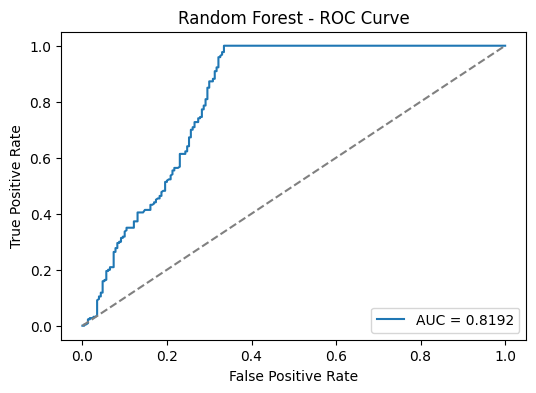

In [ ]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== Random Forest - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save model
joblib.dump(pipe, "fire_predictor_rf.pkl")
print("Saved model to fire_predictor_rf.pkl")

Saved model to fire_predictor_rf.pkl
